In [1]:
from __future__ import division
import time
import tensorflow as tf
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
from PIL import Image
from scipy.misc import toimage
from cs231n.data_utils import load_CIFAR10

import os.path
import os
from tensorflow.python.framework import ops

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/")
X_train= mnist.train.images.reshape([-1,28,28,1])
y_train= mnist.train.labels
X_test = mnist.test.images.reshape([-1,28,28,1])
y_test= mnist.test.labels
X_val=mnist.validation.images.reshape([-1,28,28,1])
y_val= mnist.validation.labels

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Train data shape:  (55000, 28, 28, 1)
Train labels shape:  (55000,)
Validation data shape:  (5000, 28, 28, 1)
Validation labels shape:  (5000,)
Test data shape:  (10000, 28, 28, 1)
Test labels shape:  (10000,)


In [3]:
from lasso_codes.lasso import lasso_fista
#from lasso_codes.lasso import lasso_fista_col
from lasso_codes.lasso import compute_lasso_grad
#from lasso_codes.lasso import compute_lasso_grad_col2

In [4]:
def run_model(session, predict, loss_val, Xd, yd,
              epochs=1, batch_size=64, print_every=100,
              training=None, plot_losses=False, X_val=None,y_val=None):
    # have tensorflow compute accuracy
    correct_prediction = tf.equal(tf.argmax(predict,1), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)

    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [loss_val,correct_prediction,accuracy]
    if training_now:
        variables[-1] = training
    
    # counter 
    total_correct=[]
    total_loss=[]
    total_loss_val=[]
    total_correct_val=[]
    iter_cnt = 0
    for e in range(epochs):
        # keep track of losses and accuracy
        correct = 0
        losses = []
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx,:],
                         y: yd[idx],
                         is_training: training_now }
            # get batch size
            actual_batch_size = yd[idx].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, corr, _ = session.run(variables,feed_dict=feed_dict)
            
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            correct += np.sum(corr)
            
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                      .format(iter_cnt,loss,np.sum(corr)/actual_batch_size))
            iter_cnt += 1
        total_correct.append(correct/Xd.shape[0])
        total_loss.append(np.sum(losses)/Xd.shape[0])
        if training:
            print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
              .format(total_loss[-1],total_correct[-1],e+1))
            [total_loss_tmp, total_correct_tmp]=run_model(session,predict,loss_val,X_val,y_val,1,batch_size)
            total_loss_val.append(total_loss_tmp[-1])
            total_correct_val.append(total_correct_tmp[-1])
        else:
            print("(Validation) Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
              .format(total_loss[-1],total_correct[-1],e+1))
            
        
        if plot_losses:
            f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=False, figsize=(12,4))

            ax1.plot(losses)
            ax1.grid(True)
            ax1.set_title('Epoch {} Loss'.format(e+1))
            ax1.set_xlabel('minibatch number')
            ax1.set_ylabel('minibatch loss')
            
            ax2.plot(list(range(1,len(total_loss)+1)), total_loss, list(range(1,len(total_loss)+1)), total_loss_val)
            ax2.grid(True)
            ax2.set_title('Epoch {} Loss'.format(e+1))
            ax2.set_xlabel('epoch')
            ax2.set_ylabel('epoch loss')
            ax2.legend(['Training','Validation'],loc="upper right")
            
            ax3.plot(list(range(1,len(total_loss)+1)), total_correct, list(range(1,len(total_loss)+1)), total_correct_val)
            ax3.grid(True)
            ax3.set_title('Epoch {} Accuracy'.format(e+1))
            ax3.set_xlabel('epoch')
            ax3.set_ylabel('epoch accuracy')
            ax3.legend(['Training','Validation'],loc="upper left")
            
            f.tight_layout()
            plt.show()
            
    if training:
        return total_loss,total_correct, total_loss_val, total_correct_val
    else:
        return total_loss,total_correct

In [5]:
def simple_model(X,y,is_training):
    padding='SAME'
    ksizes=[1,3,3,1]
    strides=[1,1,1,1]
    rates=[1,1,1,1]
    dims=[25,28,28,1]
    lambda1=0.01
    bsize=dims[0]
    
    @ops.RegisterGradient("LassoFistaGrad")
    def _lasso_fista_identity_grad(op, grad):

        D = op.inputs[0]
        X = op.inputs[1]
        lambda1=op.inputs[2]
        A = op.inputs[3]

        [lambda_grad, X_grad, D_grad]= compute_lasso_grad(X=X, A=A, D=D, lambda1=lambda1, grad_output=grad,
                                                        ksizes=ksizes, strides=strides, rates=rates,
                                                          padding=padding, params=dims,NonNeg=True)

        lambda_grad=tf.expand_dims(lambda_grad,0)
        A_grad=grad
        
        lambda_grad=None

        return[D_grad, X_grad, lambda_grad, A_grad,None,None,None,None, None]
    
    
    g = tf.get_default_graph()
    with g.gradient_override_map({'LassoFista': 'LassoFistaGrad'}):    
        _module=tf.load_op_library('lasso_codes/lasso_fista.so') #tf.sysconfig.get_lib()+

        D1=tf.get_variable("Dict1", shape=[9,50])
        #lambda1=tf.get_variable("lambda1", shape=[1])
        
        A1_tmp= lasso_fista(Dict=D1,
                 input=X,
                 lambda1=lambda1,
                 ksizes=ksizes,
                 strides=strides,
                 rates=rates,
                 padding=padding,
                 maxItr=500,
                 NonNeg=True,
                 debug=False,
                 name='lasso')
      
        if (padding=='VALID'):
            pad=0
        else:
            pad=1
        
        A_n=_module.lasso_fista(D1, X, lambda1, A1_tmp, ksizes, strides, rates, pad, dims)
        A1= A_n + tf.stop_gradient(A1_tmp-A_n)
    
    A1_dense=tf.reshape(A1,[bsize,-1])
    #print(A1_dense)
    W=tf.get_variable("Wclass", shape=[10,(28*28*50)])
    #W=np.random.rand(10, A1_dense.shape[1])
    y_out=tf.matmul(a=A1_dense, b=W, transpose_a=False, transpose_b=True)



    #grad_D = tf.gradients(loss, D1)
    #grad_X = tf.gradients(loss, X)
    #grad_lambda1 = tf.gradients(loss, lambda1)
    #y_out
    return(y_out)

In [6]:
# Define the Graph
tf.reset_default_graph()
is_training = tf.placeholder(tf.bool)
X= tf.placeholder(tf.float32, [None,28,28,1])
y= tf.placeholder(tf.int64,[None])
y_out=simple_model(X,y,is_training)

In [7]:
total_loss = tf.losses.softmax_cross_entropy(tf.one_hot(y,10),logits=y_out)
#mean_loss = tf.reduce_mean(total_loss) + tf.add_n(tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES))
mean_loss = tf.reduce_mean(total_loss)

# define our optimizer
optimizer = tf.train.AdamOptimizer(1e-5) # select optimizer and set learning rate

# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

#y_onehot=tf.one_hot(y, 10)
#y_onehot=tf.cast(y_onehot,tf.float32)
#err=y_onehot-y_out
#loss=tf.norm(err,2)

Training
Iteration 0: with minibatch training loss = 2.34 and accuracy of 0.12
Iteration 100: with minibatch training loss = 2.03 and accuracy of 0.32
Iteration 200: with minibatch training loss = 1.65 and accuracy of 0.72
Iteration 300: with minibatch training loss = 1.41 and accuracy of 0.84
Iteration 400: with minibatch training loss = 1.21 and accuracy of 0.76
Iteration 500: with minibatch training loss = 1.28 and accuracy of 0.72
Iteration 600: with minibatch training loss = 0.918 and accuracy of 0.88
Iteration 700: with minibatch training loss = 0.741 and accuracy of 0.92
Iteration 800: with minibatch training loss = 0.767 and accuracy of 0.92
Iteration 900: with minibatch training loss = 0.844 and accuracy of 0.76
Iteration 1000: with minibatch training loss = 0.491 and accuracy of 1
Iteration 1100: with minibatch training loss = 0.685 and accuracy of 0.92
Iteration 1200: with minibatch training loss = 0.73 and accuracy of 0.76
Iteration 1300: with minibatch training loss = 0.45

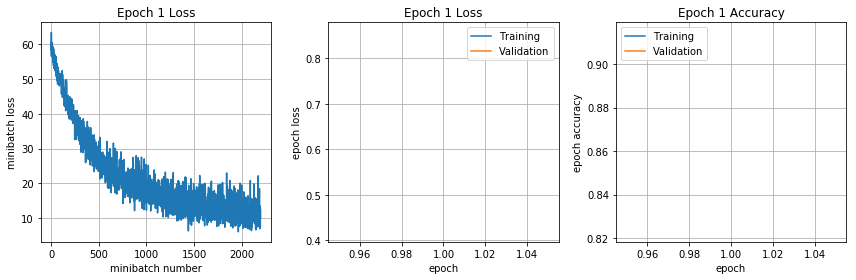

Iteration 2200: with minibatch training loss = 0.57 and accuracy of 0.84
Iteration 2300: with minibatch training loss = 0.465 and accuracy of 0.84
Iteration 2400: with minibatch training loss = 0.407 and accuracy of 0.96
Iteration 2500: with minibatch training loss = 0.393 and accuracy of 0.92
Iteration 2600: with minibatch training loss = 0.428 and accuracy of 0.92
Iteration 2700: with minibatch training loss = 0.375 and accuracy of 0.96
Iteration 2800: with minibatch training loss = 0.28 and accuracy of 0.96
Iteration 2900: with minibatch training loss = 0.215 and accuracy of 1
Iteration 3000: with minibatch training loss = 0.256 and accuracy of 1
Iteration 3100: with minibatch training loss = 0.415 and accuracy of 0.84
Iteration 3200: with minibatch training loss = 0.166 and accuracy of 1
Iteration 3300: with minibatch training loss = 0.306 and accuracy of 0.92
Iteration 3400: with minibatch training loss = 0.55 and accuracy of 0.8
Iteration 3500: with minibatch training loss = 0.18

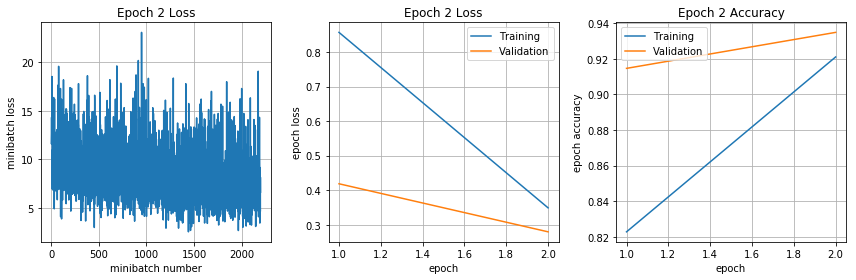

Iteration 4400: with minibatch training loss = 0.404 and accuracy of 0.92
Iteration 4500: with minibatch training loss = 0.326 and accuracy of 0.92
Iteration 4600: with minibatch training loss = 0.293 and accuracy of 0.96
Iteration 4700: with minibatch training loss = 0.26 and accuracy of 0.92
Iteration 4800: with minibatch training loss = 0.313 and accuracy of 0.92
Iteration 4900: with minibatch training loss = 0.199 and accuracy of 1
Iteration 5000: with minibatch training loss = 0.164 and accuracy of 1
Iteration 5100: with minibatch training loss = 0.117 and accuracy of 1
Iteration 5200: with minibatch training loss = 0.158 and accuracy of 1
Iteration 5300: with minibatch training loss = 0.305 and accuracy of 0.88
Iteration 5400: with minibatch training loss = 0.095 and accuracy of 1
Iteration 5500: with minibatch training loss = 0.211 and accuracy of 0.92
Iteration 5600: with minibatch training loss = 0.499 and accuracy of 0.88
Iteration 5700: with minibatch training loss = 0.124 a

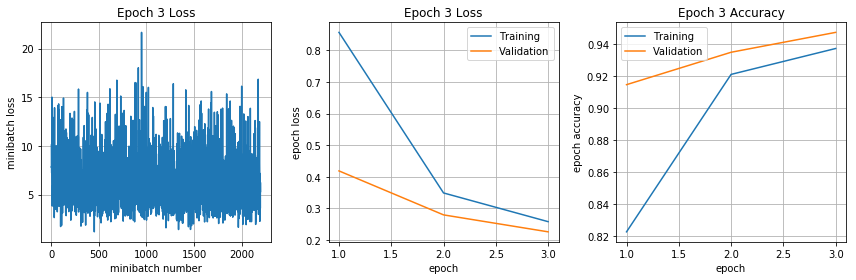

Iteration 6600: with minibatch training loss = 0.321 and accuracy of 0.92
Iteration 6700: with minibatch training loss = 0.265 and accuracy of 0.96
Iteration 6800: with minibatch training loss = 0.245 and accuracy of 0.96
Iteration 6900: with minibatch training loss = 0.204 and accuracy of 0.92
Iteration 7000: with minibatch training loss = 0.247 and accuracy of 0.92
Iteration 7100: with minibatch training loss = 0.128 and accuracy of 1
Iteration 7200: with minibatch training loss = 0.116 and accuracy of 1
Iteration 7300: with minibatch training loss = 0.0762 and accuracy of 1
Iteration 7400: with minibatch training loss = 0.118 and accuracy of 1
Iteration 7500: with minibatch training loss = 0.253 and accuracy of 0.96
Iteration 7600: with minibatch training loss = 0.0651 and accuracy of 1
Iteration 7700: with minibatch training loss = 0.17 and accuracy of 0.92
Iteration 7800: with minibatch training loss = 0.466 and accuracy of 0.88
Iteration 7900: with minibatch training loss = 0.093

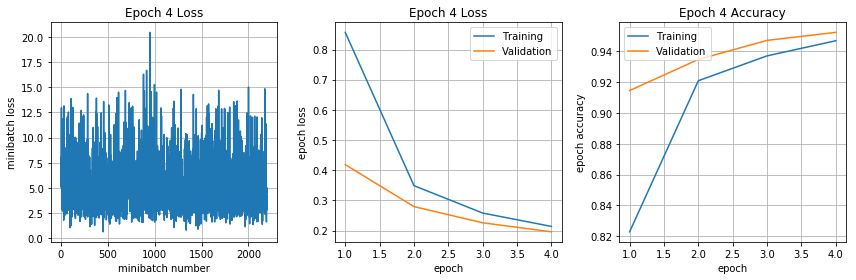

Iteration 8800: with minibatch training loss = 0.268 and accuracy of 0.92
Iteration 8900: with minibatch training loss = 0.229 and accuracy of 0.96
Iteration 9000: with minibatch training loss = 0.214 and accuracy of 0.96
Iteration 9100: with minibatch training loss = 0.17 and accuracy of 0.92
Iteration 9200: with minibatch training loss = 0.197 and accuracy of 0.92
Iteration 9300: with minibatch training loss = 0.0929 and accuracy of 1
Iteration 9400: with minibatch training loss = 0.0903 and accuracy of 1
Iteration 9500: with minibatch training loss = 0.0567 and accuracy of 1
Iteration 9600: with minibatch training loss = 0.096 and accuracy of 1
Iteration 9700: with minibatch training loss = 0.223 and accuracy of 0.96
Iteration 9800: with minibatch training loss = 0.0494 and accuracy of 1
Iteration 9900: with minibatch training loss = 0.147 and accuracy of 0.96
Iteration 10000: with minibatch training loss = 0.439 and accuracy of 0.88
Iteration 10100: with minibatch training loss = 0

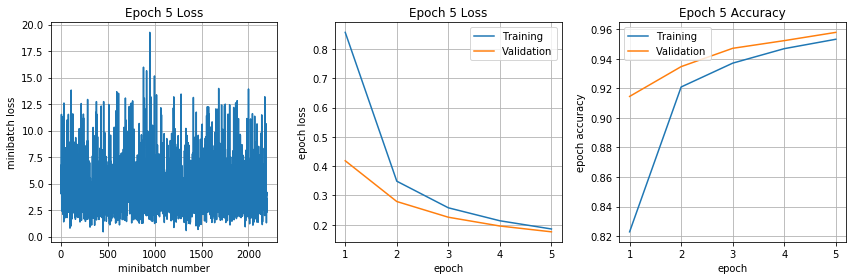

Iteration 11000: with minibatch training loss = 0.232 and accuracy of 0.92
Iteration 11100: with minibatch training loss = 0.203 and accuracy of 1
Iteration 11200: with minibatch training loss = 0.191 and accuracy of 0.96
Iteration 11300: with minibatch training loss = 0.148 and accuracy of 0.92
Iteration 11400: with minibatch training loss = 0.158 and accuracy of 0.92
Iteration 11500: with minibatch training loss = 0.0729 and accuracy of 1
Iteration 11600: with minibatch training loss = 0.0732 and accuracy of 1
Iteration 11700: with minibatch training loss = 0.0457 and accuracy of 1
Iteration 11800: with minibatch training loss = 0.0819 and accuracy of 1
Iteration 11900: with minibatch training loss = 0.202 and accuracy of 0.96
Iteration 12000: with minibatch training loss = 0.0398 and accuracy of 1
Iteration 12100: with minibatch training loss = 0.131 and accuracy of 0.96
Iteration 12200: with minibatch training loss = 0.415 and accuracy of 0.88
Iteration 12300: with minibatch traini

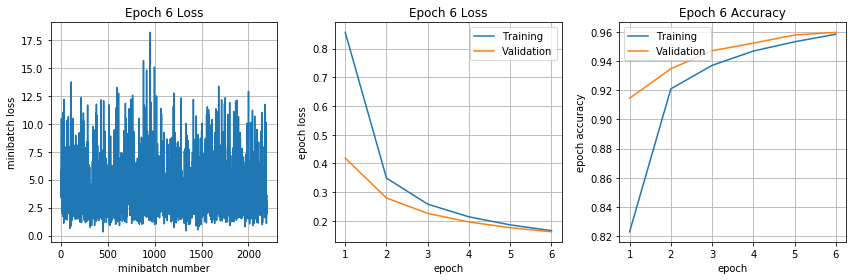

Iteration 13200: with minibatch training loss = 0.205 and accuracy of 0.96
Iteration 13300: with minibatch training loss = 0.183 and accuracy of 1
Iteration 13400: with minibatch training loss = 0.171 and accuracy of 0.96
Iteration 13500: with minibatch training loss = 0.132 and accuracy of 0.96
Iteration 13600: with minibatch training loss = 0.128 and accuracy of 0.96
Iteration 13700: with minibatch training loss = 0.0606 and accuracy of 1
Iteration 13800: with minibatch training loss = 0.0616 and accuracy of 1
Iteration 13900: with minibatch training loss = 0.0391 and accuracy of 1
Iteration 14000: with minibatch training loss = 0.0726 and accuracy of 1
Iteration 14100: with minibatch training loss = 0.186 and accuracy of 0.96
Iteration 14200: with minibatch training loss = 0.033 and accuracy of 1
Iteration 14300: with minibatch training loss = 0.119 and accuracy of 0.96
Iteration 14400: with minibatch training loss = 0.394 and accuracy of 0.88
Iteration 14500: with minibatch trainin

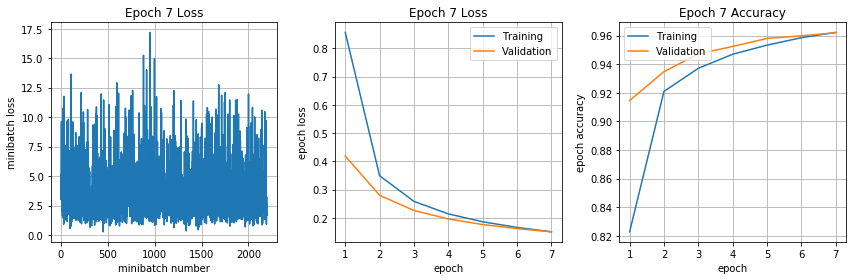

Iteration 15400: with minibatch training loss = 0.184 and accuracy of 0.96
Iteration 15500: with minibatch training loss = 0.166 and accuracy of 1
Iteration 15600: with minibatch training loss = 0.157 and accuracy of 0.96
Iteration 15700: with minibatch training loss = 0.119 and accuracy of 0.96
Iteration 15800: with minibatch training loss = 0.105 and accuracy of 0.96
Iteration 15900: with minibatch training loss = 0.0519 and accuracy of 1
Iteration 16000: with minibatch training loss = 0.0528 and accuracy of 1
Iteration 16100: with minibatch training loss = 0.0344 and accuracy of 1
Iteration 16200: with minibatch training loss = 0.0655 and accuracy of 1
Iteration 16300: with minibatch training loss = 0.174 and accuracy of 0.96
Iteration 16400: with minibatch training loss = 0.0284 and accuracy of 1
Iteration 16500: with minibatch training loss = 0.11 and accuracy of 0.96
Iteration 16600: with minibatch training loss = 0.375 and accuracy of 0.88
Iteration 16700: with minibatch trainin

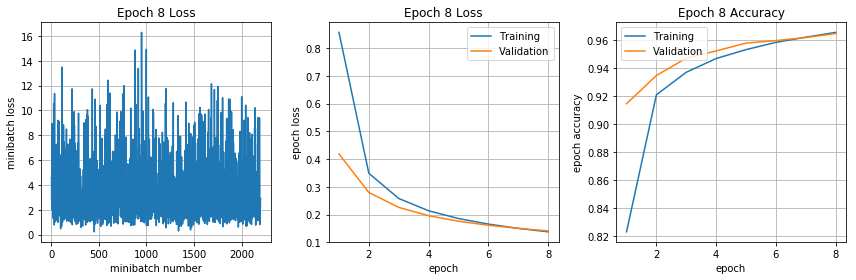

Iteration 17600: with minibatch training loss = 0.166 and accuracy of 0.96
Iteration 17700: with minibatch training loss = 0.152 and accuracy of 1
Iteration 17800: with minibatch training loss = 0.143 and accuracy of 0.96
Iteration 17900: with minibatch training loss = 0.108 and accuracy of 0.96
Iteration 18000: with minibatch training loss = 0.0873 and accuracy of 0.96
Iteration 18100: with minibatch training loss = 0.0454 and accuracy of 1
Iteration 18200: with minibatch training loss = 0.0461 and accuracy of 1
Iteration 18300: with minibatch training loss = 0.0313 and accuracy of 1
Iteration 18400: with minibatch training loss = 0.0597 and accuracy of 1
Iteration 18500: with minibatch training loss = 0.164 and accuracy of 0.96
Iteration 18600: with minibatch training loss = 0.0248 and accuracy of 1
Iteration 18700: with minibatch training loss = 0.103 and accuracy of 0.96
Iteration 18800: with minibatch training loss = 0.358 and accuracy of 0.88
Iteration 18900: with minibatch train

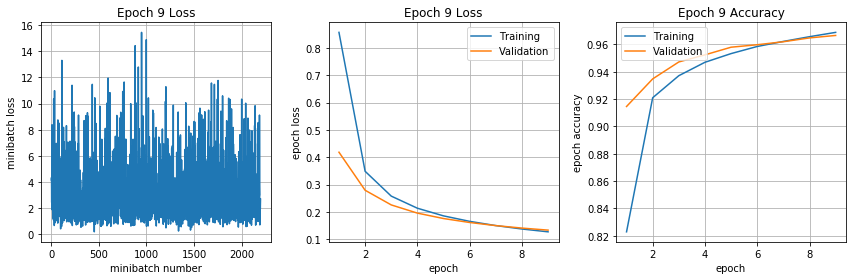

Iteration 19800: with minibatch training loss = 0.152 and accuracy of 0.96
Iteration 19900: with minibatch training loss = 0.14 and accuracy of 1
Iteration 20000: with minibatch training loss = 0.131 and accuracy of 0.96
Iteration 20100: with minibatch training loss = 0.0989 and accuracy of 0.96
Iteration 20200: with minibatch training loss = 0.0733 and accuracy of 1
Iteration 20300: with minibatch training loss = 0.0404 and accuracy of 1
Iteration 20400: with minibatch training loss = 0.0408 and accuracy of 1
Iteration 20500: with minibatch training loss = 0.0286 and accuracy of 1
Iteration 20600: with minibatch training loss = 0.0549 and accuracy of 1
Iteration 20700: with minibatch training loss = 0.155 and accuracy of 0.96
Iteration 20800: with minibatch training loss = 0.022 and accuracy of 1
Iteration 20900: with minibatch training loss = 0.0969 and accuracy of 0.96
Iteration 21000: with minibatch training loss = 0.342 and accuracy of 0.88
Iteration 21100: with minibatch training

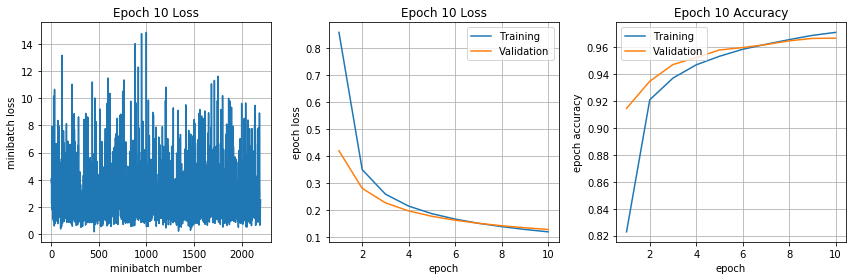

Iteration 22000: with minibatch training loss = 0.138 and accuracy of 0.96
Iteration 22100: with minibatch training loss = 0.131 and accuracy of 1
Iteration 22200: with minibatch training loss = 0.121 and accuracy of 0.96
Iteration 22300: with minibatch training loss = 0.091 and accuracy of 0.96
Iteration 22400: with minibatch training loss = 0.0627 and accuracy of 1
Iteration 22500: with minibatch training loss = 0.0367 and accuracy of 1
Iteration 22600: with minibatch training loss = 0.0365 and accuracy of 1
Iteration 22700: with minibatch training loss = 0.0265 and accuracy of 1
Iteration 22800: with minibatch training loss = 0.0509 and accuracy of 1
Iteration 22900: with minibatch training loss = 0.147 and accuracy of 0.96
Iteration 23000: with minibatch training loss = 0.0198 and accuracy of 1
Iteration 23100: with minibatch training loss = 0.0915 and accuracy of 0.96
Iteration 23200: with minibatch training loss = 0.326 and accuracy of 0.88
Iteration 23300: with minibatch trainin

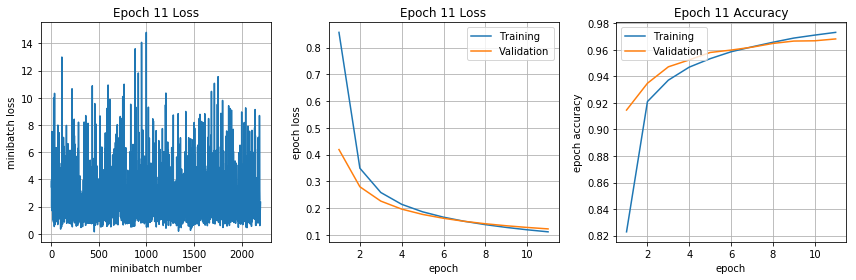

Iteration 24200: with minibatch training loss = 0.127 and accuracy of 0.96
Iteration 24300: with minibatch training loss = 0.122 and accuracy of 1
Iteration 24400: with minibatch training loss = 0.112 and accuracy of 0.96
Iteration 24500: with minibatch training loss = 0.0845 and accuracy of 0.96
Iteration 24600: with minibatch training loss = 0.0542 and accuracy of 1
Iteration 24700: with minibatch training loss = 0.0333 and accuracy of 1
Iteration 24800: with minibatch training loss = 0.0329 and accuracy of 1
Iteration 24900: with minibatch training loss = 0.0251 and accuracy of 1
Iteration 25000: with minibatch training loss = 0.047 and accuracy of 1
Iteration 25100: with minibatch training loss = 0.14 and accuracy of 0.96
Iteration 25200: with minibatch training loss = 0.0178 and accuracy of 1
Iteration 25300: with minibatch training loss = 0.0866 and accuracy of 1
Iteration 25400: with minibatch training loss = 0.311 and accuracy of 0.88
Iteration 25500: with minibatch training lo

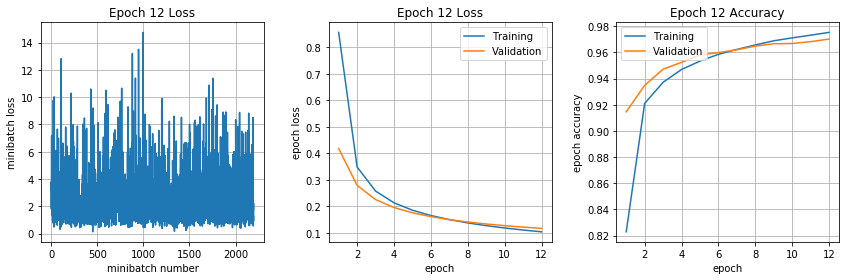

Iteration 26400: with minibatch training loss = 0.117 and accuracy of 0.96
Iteration 26500: with minibatch training loss = 0.116 and accuracy of 1
Iteration 26600: with minibatch training loss = 0.104 and accuracy of 0.96
Iteration 26700: with minibatch training loss = 0.0782 and accuracy of 0.96
Iteration 26800: with minibatch training loss = 0.0474 and accuracy of 1
Iteration 26900: with minibatch training loss = 0.0308 and accuracy of 1
Iteration 27000: with minibatch training loss = 0.0302 and accuracy of 1
Iteration 27100: with minibatch training loss = 0.0235 and accuracy of 1
Iteration 27200: with minibatch training loss = 0.0439 and accuracy of 1
Iteration 27300: with minibatch training loss = 0.132 and accuracy of 0.96
Iteration 27400: with minibatch training loss = 0.0163 and accuracy of 1
Iteration 27500: with minibatch training loss = 0.0832 and accuracy of 1
Iteration 27600: with minibatch training loss = 0.297 and accuracy of 0.88
Iteration 27700: with minibatch training 

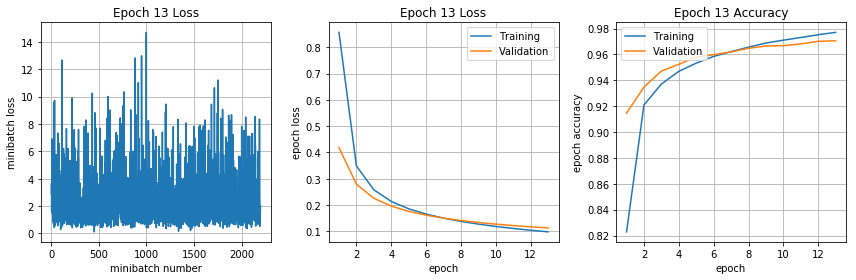

Iteration 28600: with minibatch training loss = 0.108 and accuracy of 0.96
Iteration 28700: with minibatch training loss = 0.109 and accuracy of 1
Iteration 28800: with minibatch training loss = 0.0975 and accuracy of 0.96
Iteration 28900: with minibatch training loss = 0.0732 and accuracy of 1
Iteration 29000: with minibatch training loss = 0.0423 and accuracy of 1
Iteration 29100: with minibatch training loss = 0.0284 and accuracy of 1
Iteration 29200: with minibatch training loss = 0.0277 and accuracy of 1
Iteration 29300: with minibatch training loss = 0.0223 and accuracy of 1
Iteration 29400: with minibatch training loss = 0.0412 and accuracy of 1
Iteration 29500: with minibatch training loss = 0.126 and accuracy of 0.96
Iteration 29600: with minibatch training loss = 0.0149 and accuracy of 1
Iteration 29700: with minibatch training loss = 0.0799 and accuracy of 1
Iteration 29800: with minibatch training loss = 0.284 and accuracy of 0.88
Iteration 29900: with minibatch training lo

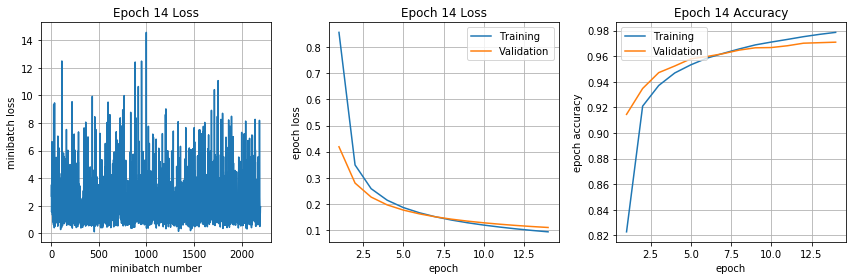

Iteration 30800: with minibatch training loss = 0.0997 and accuracy of 0.96
Iteration 30900: with minibatch training loss = 0.104 and accuracy of 1
Iteration 31000: with minibatch training loss = 0.0917 and accuracy of 0.96
Iteration 31100: with minibatch training loss = 0.0686 and accuracy of 1
Iteration 31200: with minibatch training loss = 0.0379 and accuracy of 1
Iteration 31300: with minibatch training loss = 0.0265 and accuracy of 1
Iteration 31400: with minibatch training loss = 0.0255 and accuracy of 1
Iteration 31500: with minibatch training loss = 0.0212 and accuracy of 1
Iteration 31600: with minibatch training loss = 0.0388 and accuracy of 1
Iteration 31700: with minibatch training loss = 0.121 and accuracy of 1
Iteration 31800: with minibatch training loss = 0.0137 and accuracy of 1
Iteration 31900: with minibatch training loss = 0.0768 and accuracy of 1
Iteration 32000: with minibatch training loss = 0.27 and accuracy of 0.88
Iteration 32100: with minibatch training loss 

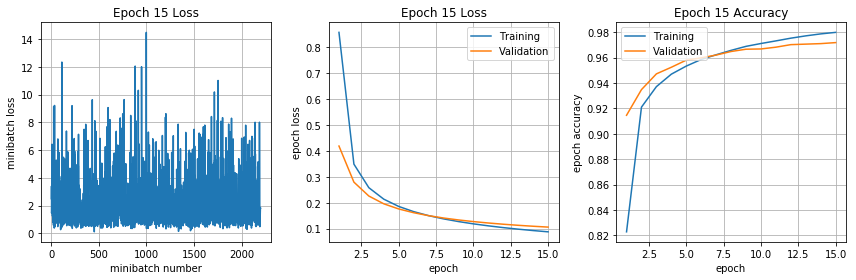

Iteration 33000: with minibatch training loss = 0.0918 and accuracy of 0.96
Iteration 33100: with minibatch training loss = 0.0986 and accuracy of 1
Iteration 33200: with minibatch training loss = 0.0851 and accuracy of 0.96
Iteration 33300: with minibatch training loss = 0.0644 and accuracy of 1
Iteration 33400: with minibatch training loss = 0.0344 and accuracy of 1
Iteration 33500: with minibatch training loss = 0.0248 and accuracy of 1
Iteration 33600: with minibatch training loss = 0.0238 and accuracy of 1
Iteration 33700: with minibatch training loss = 0.0202 and accuracy of 1
Iteration 33800: with minibatch training loss = 0.0365 and accuracy of 1
Iteration 33900: with minibatch training loss = 0.116 and accuracy of 1
Iteration 34000: with minibatch training loss = 0.0127 and accuracy of 1
Iteration 34100: with minibatch training loss = 0.074 and accuracy of 1
Iteration 34200: with minibatch training loss = 0.256 and accuracy of 0.88
Iteration 34300: with minibatch training loss

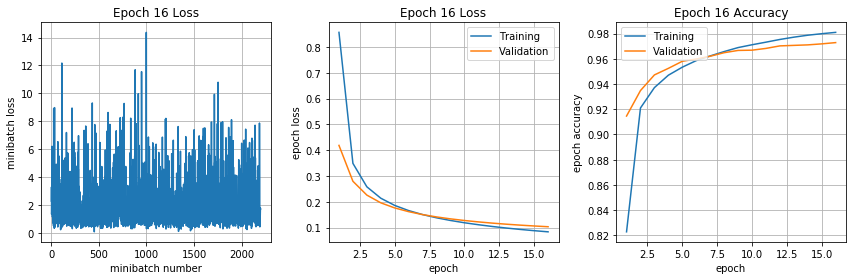

Iteration 35200: with minibatch training loss = 0.0846 and accuracy of 0.96
Iteration 35300: with minibatch training loss = 0.0937 and accuracy of 1
Iteration 35400: with minibatch training loss = 0.0806 and accuracy of 0.96
Iteration 35500: with minibatch training loss = 0.0607 and accuracy of 1
Iteration 35600: with minibatch training loss = 0.0315 and accuracy of 1
Iteration 35700: with minibatch training loss = 0.0234 and accuracy of 1
Iteration 35800: with minibatch training loss = 0.0222 and accuracy of 1
Iteration 35900: with minibatch training loss = 0.0194 and accuracy of 1
Iteration 36000: with minibatch training loss = 0.0345 and accuracy of 1
Iteration 36100: with minibatch training loss = 0.111 and accuracy of 1
Iteration 36200: with minibatch training loss = 0.0117 and accuracy of 1
Iteration 36300: with minibatch training loss = 0.0713 and accuracy of 1
Iteration 36400: with minibatch training loss = 0.246 and accuracy of 0.88
Iteration 36500: with minibatch training los

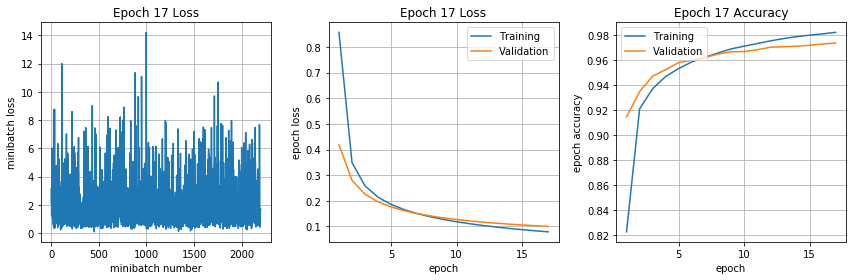

Iteration 37400: with minibatch training loss = 0.078 and accuracy of 0.96
Iteration 37500: with minibatch training loss = 0.0897 and accuracy of 1
Iteration 37600: with minibatch training loss = 0.076 and accuracy of 0.96
Iteration 37700: with minibatch training loss = 0.0574 and accuracy of 1
Iteration 37800: with minibatch training loss = 0.0291 and accuracy of 1
Iteration 37900: with minibatch training loss = 0.0221 and accuracy of 1
Iteration 38000: with minibatch training loss = 0.0208 and accuracy of 1
Iteration 38100: with minibatch training loss = 0.0186 and accuracy of 1
Iteration 38200: with minibatch training loss = 0.0327 and accuracy of 1
Iteration 38300: with minibatch training loss = 0.107 and accuracy of 1
Iteration 38400: with minibatch training loss = 0.0109 and accuracy of 1
Iteration 38500: with minibatch training loss = 0.069 and accuracy of 1
Iteration 38600: with minibatch training loss = 0.234 and accuracy of 0.88
Iteration 38700: with minibatch training loss =

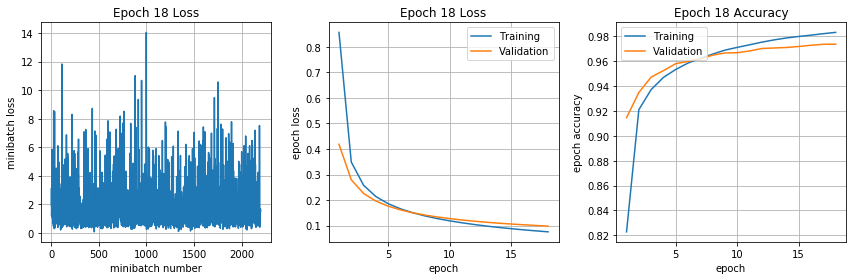

Iteration 39600: with minibatch training loss = 0.0717 and accuracy of 0.96
Iteration 39700: with minibatch training loss = 0.0856 and accuracy of 1
Iteration 39800: with minibatch training loss = 0.0706 and accuracy of 0.96
Iteration 39900: with minibatch training loss = 0.0543 and accuracy of 1
Iteration 40000: with minibatch training loss = 0.027 and accuracy of 1
Iteration 40100: with minibatch training loss = 0.0212 and accuracy of 1
Iteration 40200: with minibatch training loss = 0.0196 and accuracy of 1
Iteration 40300: with minibatch training loss = 0.0179 and accuracy of 1
Iteration 40400: with minibatch training loss = 0.0311 and accuracy of 1
Iteration 40500: with minibatch training loss = 0.102 and accuracy of 1
Iteration 40600: with minibatch training loss = 0.0102 and accuracy of 1
Iteration 40700: with minibatch training loss = 0.0667 and accuracy of 1
Iteration 40800: with minibatch training loss = 0.223 and accuracy of 0.88
Iteration 40900: with minibatch training loss

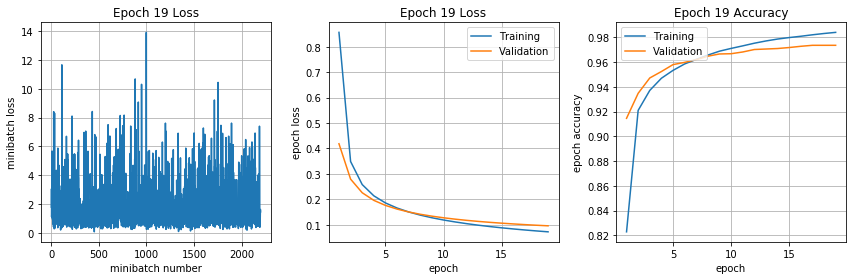

Iteration 41800: with minibatch training loss = 0.0661 and accuracy of 0.96
Iteration 41900: with minibatch training loss = 0.0821 and accuracy of 1
Iteration 42000: with minibatch training loss = 0.0674 and accuracy of 0.96
Iteration 42100: with minibatch training loss = 0.0515 and accuracy of 1
Iteration 42200: with minibatch training loss = 0.0252 and accuracy of 1
Iteration 42300: with minibatch training loss = 0.02 and accuracy of 1
Iteration 42400: with minibatch training loss = 0.0186 and accuracy of 1
Iteration 42500: with minibatch training loss = 0.0172 and accuracy of 1
Iteration 42600: with minibatch training loss = 0.0295 and accuracy of 1
Iteration 42700: with minibatch training loss = 0.0981 and accuracy of 1
Iteration 42800: with minibatch training loss = 0.0095 and accuracy of 1
Iteration 42900: with minibatch training loss = 0.0652 and accuracy of 1
Iteration 43000: with minibatch training loss = 0.211 and accuracy of 0.88
Iteration 43100: with minibatch training loss

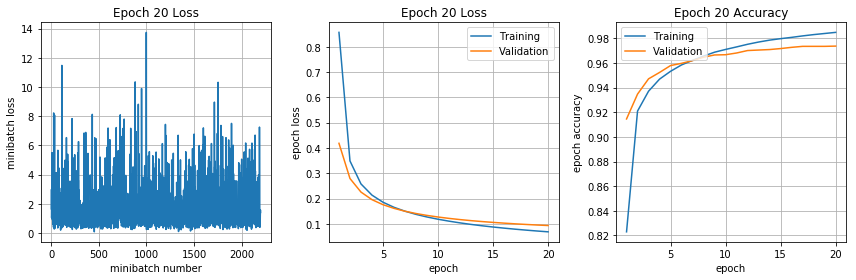

Iteration 44000: with minibatch training loss = 0.0615 and accuracy of 0.96
Iteration 44100: with minibatch training loss = 0.0787 and accuracy of 1
Iteration 44200: with minibatch training loss = 0.063 and accuracy of 1
Iteration 44300: with minibatch training loss = 0.0489 and accuracy of 1
Iteration 44400: with minibatch training loss = 0.0237 and accuracy of 1
Iteration 44500: with minibatch training loss = 0.019 and accuracy of 1
Iteration 44600: with minibatch training loss = 0.0177 and accuracy of 1
Iteration 44700: with minibatch training loss = 0.0164 and accuracy of 1
Iteration 44800: with minibatch training loss = 0.0282 and accuracy of 1
Iteration 44900: with minibatch training loss = 0.0948 and accuracy of 1
Iteration 45000: with minibatch training loss = 0.00886 and accuracy of 1
Iteration 45100: with minibatch training loss = 0.0636 and accuracy of 1
Iteration 45200: with minibatch training loss = 0.202 and accuracy of 0.88
Iteration 45300: with minibatch training loss =

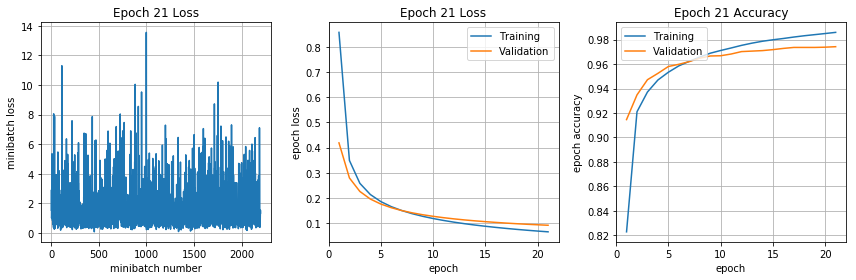

Iteration 46200: with minibatch training loss = 0.0573 and accuracy of 0.96
Iteration 46300: with minibatch training loss = 0.0757 and accuracy of 1
Iteration 46400: with minibatch training loss = 0.0602 and accuracy of 1
Iteration 46500: with minibatch training loss = 0.0468 and accuracy of 1
Iteration 46600: with minibatch training loss = 0.0222 and accuracy of 1
Iteration 46700: with minibatch training loss = 0.0181 and accuracy of 1
Iteration 46800: with minibatch training loss = 0.0168 and accuracy of 1
Iteration 46900: with minibatch training loss = 0.0159 and accuracy of 1
Iteration 47000: with minibatch training loss = 0.027 and accuracy of 1
Iteration 47100: with minibatch training loss = 0.0912 and accuracy of 1
Iteration 47200: with minibatch training loss = 0.00835 and accuracy of 1
Iteration 47300: with minibatch training loss = 0.062 and accuracy of 1
Iteration 47400: with minibatch training loss = 0.192 and accuracy of 0.92
Iteration 47500: with minibatch training loss =

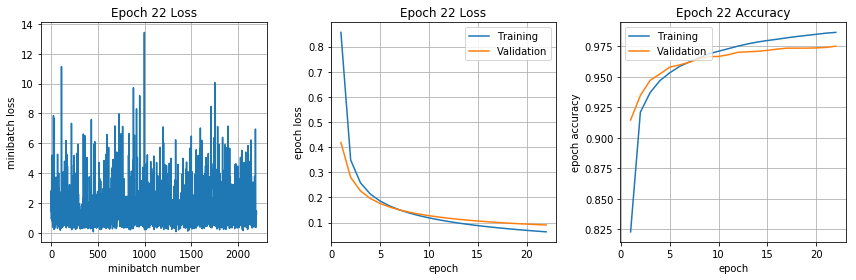

Iteration 48400: with minibatch training loss = 0.0534 and accuracy of 1
Iteration 48500: with minibatch training loss = 0.0728 and accuracy of 1
Iteration 48600: with minibatch training loss = 0.0565 and accuracy of 1
Iteration 48700: with minibatch training loss = 0.0446 and accuracy of 1
Iteration 48800: with minibatch training loss = 0.021 and accuracy of 1
Iteration 48900: with minibatch training loss = 0.0172 and accuracy of 1
Iteration 49000: with minibatch training loss = 0.016 and accuracy of 1
Iteration 49100: with minibatch training loss = 0.0152 and accuracy of 1
Iteration 49200: with minibatch training loss = 0.0257 and accuracy of 1
Iteration 49300: with minibatch training loss = 0.0877 and accuracy of 1
Iteration 49400: with minibatch training loss = 0.00792 and accuracy of 1
Iteration 49500: with minibatch training loss = 0.0606 and accuracy of 1
Iteration 49600: with minibatch training loss = 0.182 and accuracy of 0.96
Iteration 49700: with minibatch training loss = 0.

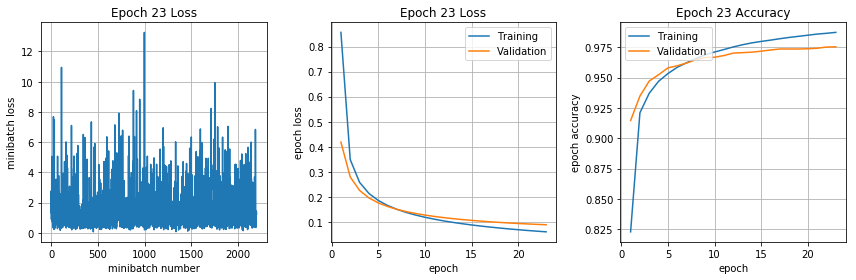

Iteration 50600: with minibatch training loss = 0.0499 and accuracy of 1
Iteration 50700: with minibatch training loss = 0.0702 and accuracy of 1
Iteration 50800: with minibatch training loss = 0.0535 and accuracy of 1
Iteration 50900: with minibatch training loss = 0.0427 and accuracy of 1
Iteration 51000: with minibatch training loss = 0.0199 and accuracy of 1
Iteration 51100: with minibatch training loss = 0.0165 and accuracy of 1
Iteration 51200: with minibatch training loss = 0.0153 and accuracy of 1
Iteration 51300: with minibatch training loss = 0.0148 and accuracy of 1
Iteration 51400: with minibatch training loss = 0.0247 and accuracy of 1
Iteration 51500: with minibatch training loss = 0.0844 and accuracy of 1
Iteration 51600: with minibatch training loss = 0.00742 and accuracy of 1
Iteration 51700: with minibatch training loss = 0.0596 and accuracy of 1
Iteration 51800: with minibatch training loss = 0.173 and accuracy of 0.92
Iteration 51900: with minibatch training loss = 

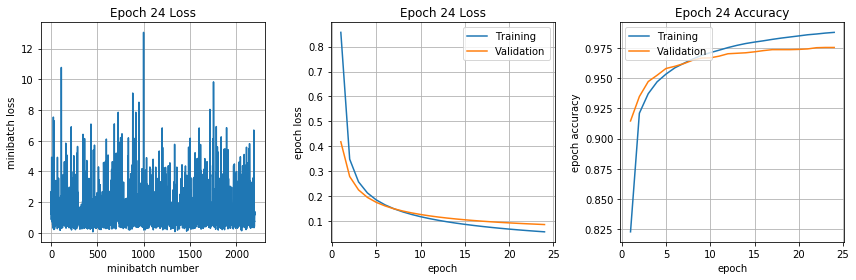

Iteration 52800: with minibatch training loss = 0.0462 and accuracy of 1
Iteration 52900: with minibatch training loss = 0.0678 and accuracy of 1
Iteration 53000: with minibatch training loss = 0.0514 and accuracy of 1
Iteration 53100: with minibatch training loss = 0.0406 and accuracy of 1
Iteration 53200: with minibatch training loss = 0.0189 and accuracy of 1
Iteration 53300: with minibatch training loss = 0.0159 and accuracy of 1
Iteration 53400: with minibatch training loss = 0.0146 and accuracy of 1
Iteration 53500: with minibatch training loss = 0.0144 and accuracy of 1
Iteration 53600: with minibatch training loss = 0.0237 and accuracy of 1
Iteration 53700: with minibatch training loss = 0.0813 and accuracy of 1
Iteration 53800: with minibatch training loss = 0.00702 and accuracy of 1
Iteration 53900: with minibatch training loss = 0.0584 and accuracy of 1
Iteration 54000: with minibatch training loss = 0.165 and accuracy of 0.96
Iteration 54100: with minibatch training loss = 

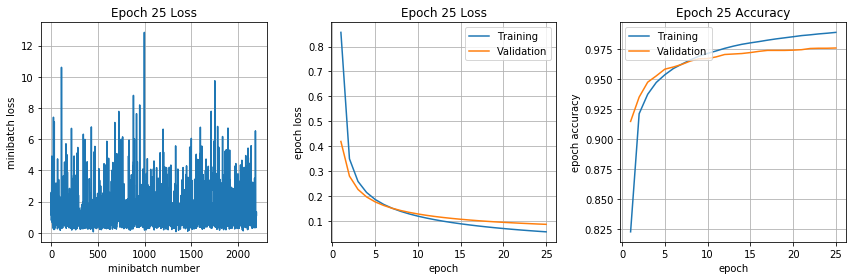

Iteration 55000: with minibatch training loss = 0.0424 and accuracy of 1
Iteration 55100: with minibatch training loss = 0.0651 and accuracy of 1
Iteration 55200: with minibatch training loss = 0.0481 and accuracy of 1
Iteration 55300: with minibatch training loss = 0.0391 and accuracy of 1
Iteration 55400: with minibatch training loss = 0.0179 and accuracy of 1
Iteration 55500: with minibatch training loss = 0.0153 and accuracy of 1
Iteration 55600: with minibatch training loss = 0.0141 and accuracy of 1
Iteration 55700: with minibatch training loss = 0.0141 and accuracy of 1
Iteration 55800: with minibatch training loss = 0.0228 and accuracy of 1
Iteration 55900: with minibatch training loss = 0.0784 and accuracy of 1
Iteration 56000: with minibatch training loss = 0.00669 and accuracy of 1
Iteration 56100: with minibatch training loss = 0.0571 and accuracy of 1
Iteration 56200: with minibatch training loss = 0.156 and accuracy of 0.96
Iteration 56300: with minibatch training loss = 

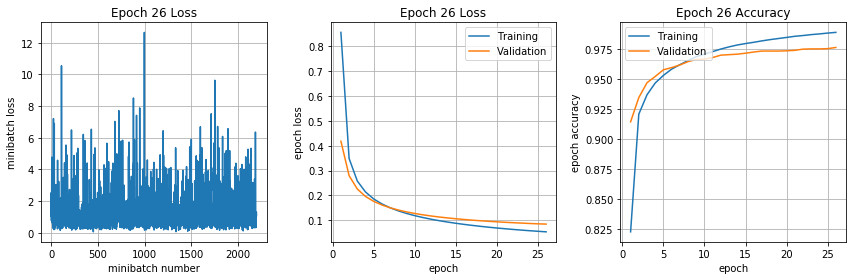

Iteration 57200: with minibatch training loss = 0.0422 and accuracy of 1
Iteration 57300: with minibatch training loss = 0.0637 and accuracy of 1
Iteration 57400: with minibatch training loss = 0.0457 and accuracy of 1
Iteration 57500: with minibatch training loss = 0.0377 and accuracy of 1
Iteration 57600: with minibatch training loss = 0.0171 and accuracy of 1
Iteration 57700: with minibatch training loss = 0.0148 and accuracy of 1
Iteration 57800: with minibatch training loss = 0.0135 and accuracy of 1
Iteration 57900: with minibatch training loss = 0.0131 and accuracy of 1
Iteration 58000: with minibatch training loss = 0.0217 and accuracy of 1
Iteration 58100: with minibatch training loss = 0.0754 and accuracy of 1
Iteration 58200: with minibatch training loss = 0.00637 and accuracy of 1
Iteration 58300: with minibatch training loss = 0.0556 and accuracy of 1
Iteration 58400: with minibatch training loss = 0.149 and accuracy of 0.96
Iteration 58500: with minibatch training loss = 

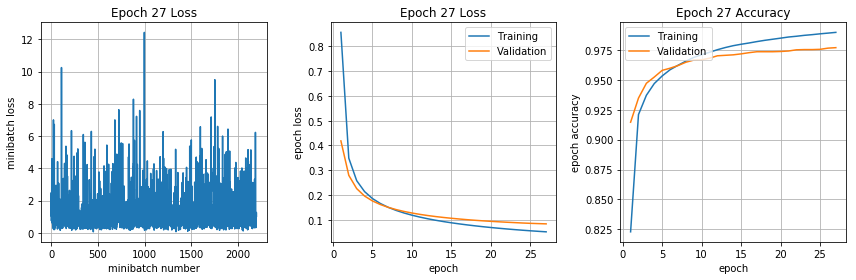

Iteration 59400: with minibatch training loss = 0.0396 and accuracy of 1
Iteration 59500: with minibatch training loss = 0.0616 and accuracy of 1
Iteration 59600: with minibatch training loss = 0.0439 and accuracy of 1
Iteration 59700: with minibatch training loss = 0.0364 and accuracy of 1
Iteration 59800: with minibatch training loss = 0.0163 and accuracy of 1
Iteration 59900: with minibatch training loss = 0.014 and accuracy of 1
Iteration 60000: with minibatch training loss = 0.013 and accuracy of 1
Iteration 60100: with minibatch training loss = 0.013 and accuracy of 1
Iteration 60200: with minibatch training loss = 0.0209 and accuracy of 1
Iteration 60300: with minibatch training loss = 0.073 and accuracy of 1
Iteration 60400: with minibatch training loss = 0.00606 and accuracy of 1
Iteration 60500: with minibatch training loss = 0.0547 and accuracy of 1
Iteration 60600: with minibatch training loss = 0.142 and accuracy of 0.96
Iteration 60700: with minibatch training loss = 0.01

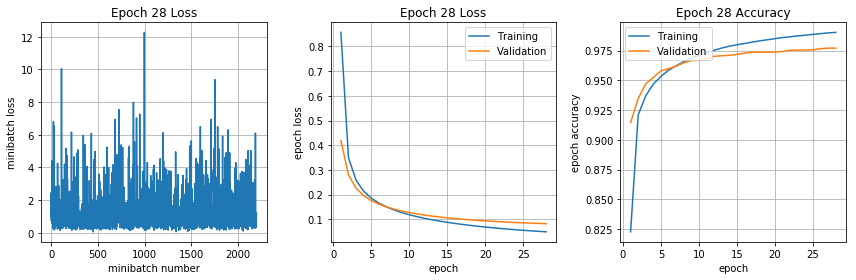

Iteration 61600: with minibatch training loss = 0.0374 and accuracy of 1
Iteration 61700: with minibatch training loss = 0.0596 and accuracy of 1
Iteration 61800: with minibatch training loss = 0.0415 and accuracy of 1
Iteration 61900: with minibatch training loss = 0.0354 and accuracy of 1
Iteration 62000: with minibatch training loss = 0.0156 and accuracy of 1
Iteration 62100: with minibatch training loss = 0.0135 and accuracy of 1
Iteration 62200: with minibatch training loss = 0.0124 and accuracy of 1
Iteration 62300: with minibatch training loss = 0.013 and accuracy of 1
Iteration 62400: with minibatch training loss = 0.0203 and accuracy of 1
Iteration 62500: with minibatch training loss = 0.0705 and accuracy of 1
Iteration 62600: with minibatch training loss = 0.00575 and accuracy of 1
Iteration 62700: with minibatch training loss = 0.0538 and accuracy of 1
Iteration 62800: with minibatch training loss = 0.139 and accuracy of 0.96
Iteration 62900: with minibatch training loss = 0

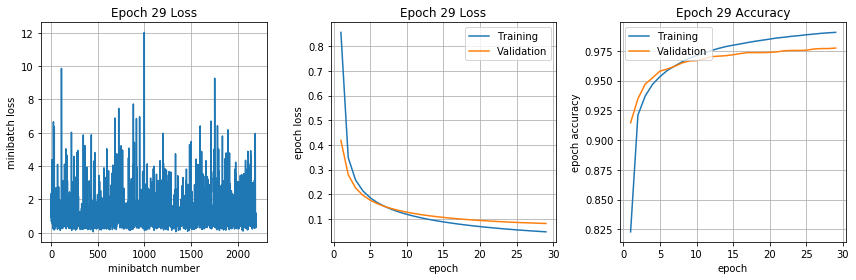

Iteration 63800: with minibatch training loss = 0.0355 and accuracy of 1
Iteration 63900: with minibatch training loss = 0.0577 and accuracy of 1
Iteration 64000: with minibatch training loss = 0.0397 and accuracy of 1
Iteration 64100: with minibatch training loss = 0.034 and accuracy of 1
Iteration 64200: with minibatch training loss = 0.0148 and accuracy of 1
Iteration 64300: with minibatch training loss = 0.0129 and accuracy of 1
Iteration 64400: with minibatch training loss = 0.0119 and accuracy of 1
Iteration 64500: with minibatch training loss = 0.0128 and accuracy of 1
Iteration 64600: with minibatch training loss = 0.0193 and accuracy of 1
Iteration 64700: with minibatch training loss = 0.0678 and accuracy of 1
Iteration 64800: with minibatch training loss = 0.00549 and accuracy of 1
Iteration 64900: with minibatch training loss = 0.0526 and accuracy of 1
Iteration 65000: with minibatch training loss = 0.133 and accuracy of 0.96
Iteration 65100: with minibatch training loss = 0

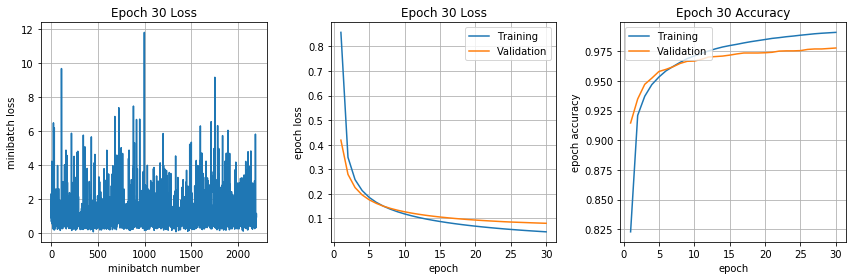

Iteration 66000: with minibatch training loss = 0.0338 and accuracy of 1
Iteration 66100: with minibatch training loss = 0.0561 and accuracy of 1
Iteration 66200: with minibatch training loss = 0.0375 and accuracy of 1
Iteration 66300: with minibatch training loss = 0.0326 and accuracy of 1
Iteration 66400: with minibatch training loss = 0.0143 and accuracy of 1
Iteration 66500: with minibatch training loss = 0.0124 and accuracy of 1
Iteration 66600: with minibatch training loss = 0.0115 and accuracy of 1
Iteration 66700: with minibatch training loss = 0.0125 and accuracy of 1
Iteration 66800: with minibatch training loss = 0.0186 and accuracy of 1
Iteration 66900: with minibatch training loss = 0.0656 and accuracy of 1
Iteration 67000: with minibatch training loss = 0.00524 and accuracy of 1
Iteration 67100: with minibatch training loss = 0.0516 and accuracy of 1
Iteration 67200: with minibatch training loss = 0.125 and accuracy of 0.96
Iteration 67300: with minibatch training loss = 

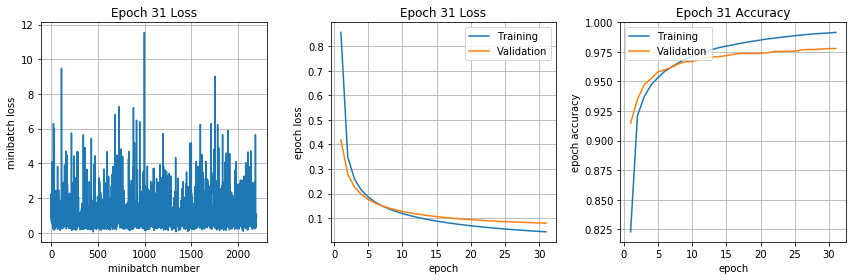

Iteration 68200: with minibatch training loss = 0.0307 and accuracy of 1
Iteration 68300: with minibatch training loss = 0.0537 and accuracy of 1
Iteration 68400: with minibatch training loss = 0.0355 and accuracy of 1
Iteration 68500: with minibatch training loss = 0.0316 and accuracy of 1
Iteration 68600: with minibatch training loss = 0.0137 and accuracy of 1
Iteration 68700: with minibatch training loss = 0.012 and accuracy of 1
Iteration 68800: with minibatch training loss = 0.0111 and accuracy of 1
Iteration 68900: with minibatch training loss = 0.0116 and accuracy of 1
Iteration 69000: with minibatch training loss = 0.018 and accuracy of 1
Iteration 69100: with minibatch training loss = 0.0635 and accuracy of 1
Iteration 69200: with minibatch training loss = 0.00498 and accuracy of 1
Iteration 69300: with minibatch training loss = 0.0504 and accuracy of 1
Iteration 69400: with minibatch training loss = 0.121 and accuracy of 0.96
Iteration 69500: with minibatch training loss = 0.

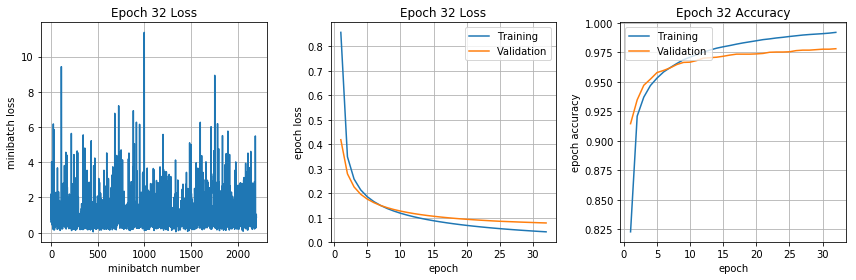

Iteration 70400: with minibatch training loss = 0.0291 and accuracy of 1
Iteration 70500: with minibatch training loss = 0.0525 and accuracy of 1
Iteration 70600: with minibatch training loss = 0.0352 and accuracy of 1
Iteration 70700: with minibatch training loss = 0.0303 and accuracy of 1
Iteration 70800: with minibatch training loss = 0.0133 and accuracy of 1
Iteration 70900: with minibatch training loss = 0.0117 and accuracy of 1
Iteration 71000: with minibatch training loss = 0.0107 and accuracy of 1
Iteration 71100: with minibatch training loss = 0.0121 and accuracy of 1
Iteration 71200: with minibatch training loss = 0.0174 and accuracy of 1
Iteration 71300: with minibatch training loss = 0.0612 and accuracy of 1
Iteration 71400: with minibatch training loss = 0.00478 and accuracy of 1
Iteration 71500: with minibatch training loss = 0.0495 and accuracy of 1
Iteration 71600: with minibatch training loss = 0.116 and accuracy of 0.96
Iteration 71700: with minibatch training loss = 

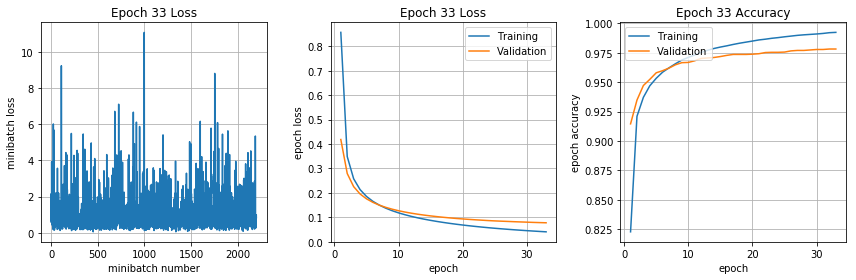

Iteration 72600: with minibatch training loss = 0.0272 and accuracy of 1
Iteration 72700: with minibatch training loss = 0.0511 and accuracy of 1
Iteration 72800: with minibatch training loss = 0.0327 and accuracy of 1
Iteration 72900: with minibatch training loss = 0.0293 and accuracy of 1
Iteration 73000: with minibatch training loss = 0.0127 and accuracy of 1
Iteration 73100: with minibatch training loss = 0.0113 and accuracy of 1
Iteration 73200: with minibatch training loss = 0.0101 and accuracy of 1
Iteration 73300: with minibatch training loss = 0.012 and accuracy of 1
Iteration 73400: with minibatch training loss = 0.0169 and accuracy of 1
Iteration 73500: with minibatch training loss = 0.0588 and accuracy of 1
Iteration 73600: with minibatch training loss = 0.00453 and accuracy of 1
Iteration 73700: with minibatch training loss = 0.0487 and accuracy of 1
Iteration 73800: with minibatch training loss = 0.107 and accuracy of 0.96
Iteration 73900: with minibatch training loss = 0

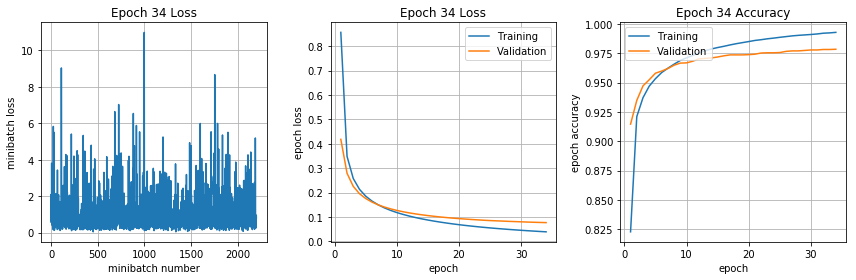

Iteration 74800: with minibatch training loss = 0.0259 and accuracy of 1
Iteration 74900: with minibatch training loss = 0.0493 and accuracy of 1
Iteration 75000: with minibatch training loss = 0.0307 and accuracy of 1
Iteration 75100: with minibatch training loss = 0.0286 and accuracy of 1
Iteration 75200: with minibatch training loss = 0.0121 and accuracy of 1
Iteration 75300: with minibatch training loss = 0.0109 and accuracy of 1
Iteration 75400: with minibatch training loss = 0.00978 and accuracy of 1
Iteration 75500: with minibatch training loss = 0.0117 and accuracy of 1
Iteration 75600: with minibatch training loss = 0.0164 and accuracy of 1
Iteration 75700: with minibatch training loss = 0.0567 and accuracy of 1
Iteration 75800: with minibatch training loss = 0.00435 and accuracy of 1
Iteration 75900: with minibatch training loss = 0.0477 and accuracy of 1
Iteration 76000: with minibatch training loss = 0.102 and accuracy of 0.96
Iteration 76100: with minibatch training loss =

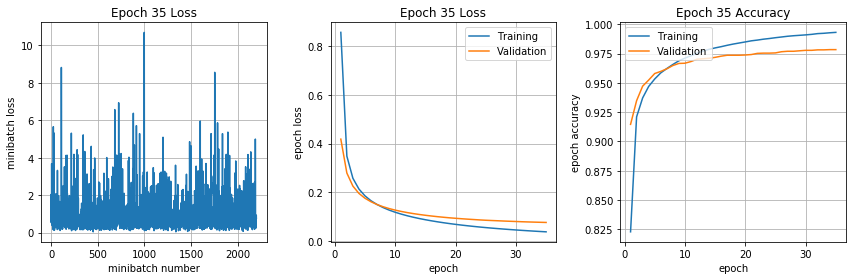

Iteration 77000: with minibatch training loss = 0.0253 and accuracy of 1
Iteration 77100: with minibatch training loss = 0.0484 and accuracy of 1
Iteration 77200: with minibatch training loss = 0.0305 and accuracy of 1
Iteration 77300: with minibatch training loss = 0.0278 and accuracy of 1
Iteration 77400: with minibatch training loss = 0.0117 and accuracy of 1
Iteration 77500: with minibatch training loss = 0.0106 and accuracy of 1
Iteration 77600: with minibatch training loss = 0.00976 and accuracy of 1
Iteration 77700: with minibatch training loss = 0.011 and accuracy of 1
Iteration 77800: with minibatch training loss = 0.0158 and accuracy of 1
Iteration 77900: with minibatch training loss = 0.0552 and accuracy of 1
Iteration 78000: with minibatch training loss = 0.00418 and accuracy of 1
Iteration 78100: with minibatch training loss = 0.0467 and accuracy of 1
Iteration 78200: with minibatch training loss = 0.098 and accuracy of 0.96
Iteration 78300: with minibatch training loss = 

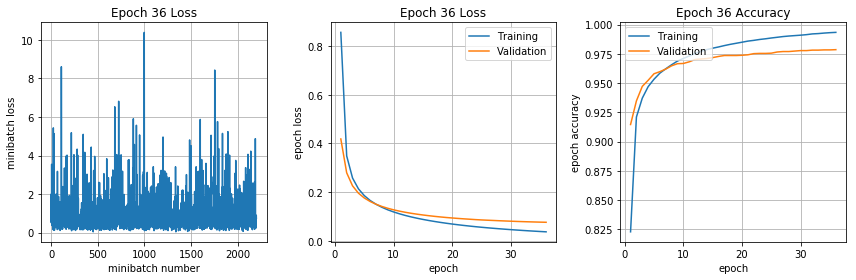

Iteration 79200: with minibatch training loss = 0.0242 and accuracy of 1
Iteration 79300: with minibatch training loss = 0.0469 and accuracy of 1
Iteration 79400: with minibatch training loss = 0.0284 and accuracy of 1
Iteration 79500: with minibatch training loss = 0.0272 and accuracy of 1
Iteration 79600: with minibatch training loss = 0.0113 and accuracy of 1
Iteration 79700: with minibatch training loss = 0.0102 and accuracy of 1
Iteration 79800: with minibatch training loss = 0.00919 and accuracy of 1
Iteration 79900: with minibatch training loss = 0.0109 and accuracy of 1
Iteration 80000: with minibatch training loss = 0.0153 and accuracy of 1
Iteration 80100: with minibatch training loss = 0.0534 and accuracy of 1
Iteration 80200: with minibatch training loss = 0.00398 and accuracy of 1
Iteration 80300: with minibatch training loss = 0.0458 and accuracy of 1
Iteration 80400: with minibatch training loss = 0.0933 and accuracy of 0.96
Iteration 80500: with minibatch training loss 

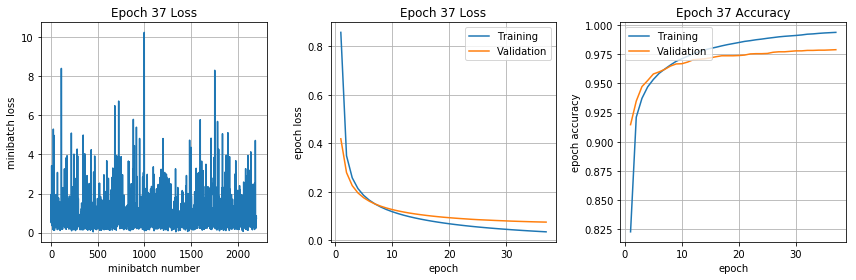

Iteration 81400: with minibatch training loss = 0.0232 and accuracy of 1
Iteration 81500: with minibatch training loss = 0.0462 and accuracy of 1
Iteration 81600: with minibatch training loss = 0.0266 and accuracy of 1
Iteration 81700: with minibatch training loss = 0.026 and accuracy of 1
Iteration 81800: with minibatch training loss = 0.0109 and accuracy of 1
Iteration 81900: with minibatch training loss = 0.00988 and accuracy of 1
Iteration 82000: with minibatch training loss = 0.00882 and accuracy of 1
Iteration 82100: with minibatch training loss = 0.0109 and accuracy of 1
Iteration 82200: with minibatch training loss = 0.0148 and accuracy of 1
Iteration 82300: with minibatch training loss = 0.0513 and accuracy of 1
Iteration 82400: with minibatch training loss = 0.00382 and accuracy of 1
Iteration 82500: with minibatch training loss = 0.0451 and accuracy of 1
Iteration 82600: with minibatch training loss = 0.0888 and accuracy of 0.96
Iteration 82700: with minibatch training loss 

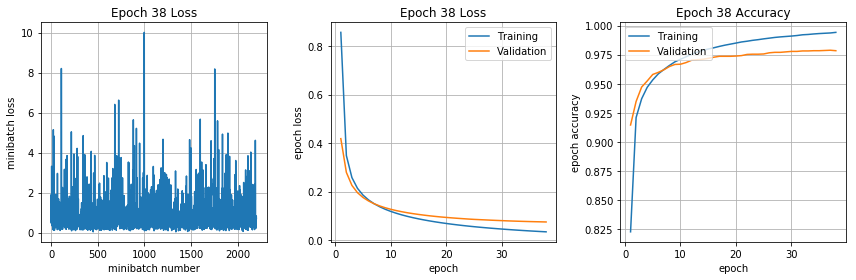

Iteration 83600: with minibatch training loss = 0.0229 and accuracy of 1
Iteration 83700: with minibatch training loss = 0.045 and accuracy of 1
Iteration 83800: with minibatch training loss = 0.0255 and accuracy of 1
Iteration 83900: with minibatch training loss = 0.0254 and accuracy of 1
Iteration 84000: with minibatch training loss = 0.0105 and accuracy of 1
Iteration 84100: with minibatch training loss = 0.0096 and accuracy of 1
Iteration 84200: with minibatch training loss = 0.00863 and accuracy of 1
Iteration 84300: with minibatch training loss = 0.0102 and accuracy of 1
Iteration 84400: with minibatch training loss = 0.0143 and accuracy of 1
Iteration 84500: with minibatch training loss = 0.0497 and accuracy of 1
Iteration 84600: with minibatch training loss = 0.00367 and accuracy of 1
Iteration 84700: with minibatch training loss = 0.0443 and accuracy of 1
Iteration 84800: with minibatch training loss = 0.0851 and accuracy of 0.96
Iteration 84900: with minibatch training loss =

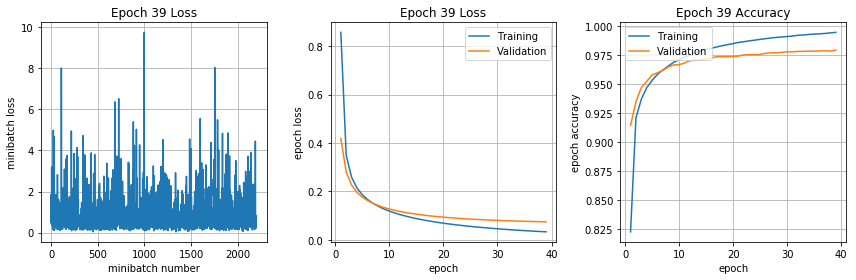

Iteration 85800: with minibatch training loss = 0.0232 and accuracy of 1
Iteration 85900: with minibatch training loss = 0.0451 and accuracy of 1
Iteration 86000: with minibatch training loss = 0.0249 and accuracy of 1
Iteration 86100: with minibatch training loss = 0.0246 and accuracy of 1
Iteration 86200: with minibatch training loss = 0.0102 and accuracy of 1
Iteration 86300: with minibatch training loss = 0.00939 and accuracy of 1
Iteration 86400: with minibatch training loss = 0.0083 and accuracy of 1
Iteration 86500: with minibatch training loss = 0.0102 and accuracy of 1
Iteration 86600: with minibatch training loss = 0.0139 and accuracy of 1
Iteration 86700: with minibatch training loss = 0.0487 and accuracy of 1
Iteration 86800: with minibatch training loss = 0.00354 and accuracy of 1
Iteration 86900: with minibatch training loss = 0.0434 and accuracy of 1
Iteration 87000: with minibatch training loss = 0.0816 and accuracy of 0.96
Iteration 87100: with minibatch training loss 

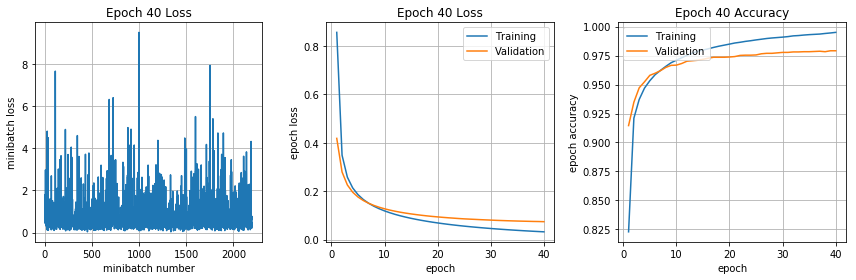

Iteration 88000: with minibatch training loss = 0.0205 and accuracy of 1
Iteration 88100: with minibatch training loss = 0.0431 and accuracy of 1
Iteration 88200: with minibatch training loss = 0.0239 and accuracy of 1
Iteration 88300: with minibatch training loss = 0.0244 and accuracy of 1
Iteration 88400: with minibatch training loss = 0.00984 and accuracy of 1
Iteration 88500: with minibatch training loss = 0.00912 and accuracy of 1
Iteration 88600: with minibatch training loss = 0.00815 and accuracy of 1
Iteration 88700: with minibatch training loss = 0.0103 and accuracy of 1
Iteration 88800: with minibatch training loss = 0.0135 and accuracy of 1
Iteration 88900: with minibatch training loss = 0.0473 and accuracy of 1
Iteration 89000: with minibatch training loss = 0.0034 and accuracy of 1
Iteration 89100: with minibatch training loss = 0.0428 and accuracy of 1
Iteration 89200: with minibatch training loss = 0.078 and accuracy of 0.96
Iteration 89300: with minibatch training loss 

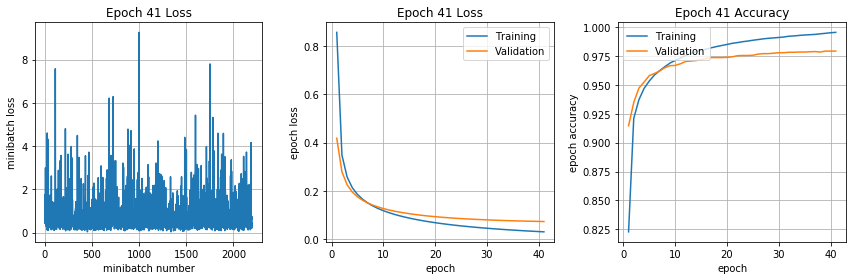

Iteration 90200: with minibatch training loss = 0.0197 and accuracy of 1
Iteration 90300: with minibatch training loss = 0.0419 and accuracy of 1
Iteration 90400: with minibatch training loss = 0.0222 and accuracy of 1
Iteration 90500: with minibatch training loss = 0.0233 and accuracy of 1
Iteration 90600: with minibatch training loss = 0.00945 and accuracy of 1
Iteration 90700: with minibatch training loss = 0.00878 and accuracy of 1
Iteration 90800: with minibatch training loss = 0.00791 and accuracy of 1
Iteration 90900: with minibatch training loss = 0.00977 and accuracy of 1
Iteration 91000: with minibatch training loss = 0.013 and accuracy of 1
Iteration 91100: with minibatch training loss = 0.0452 and accuracy of 1
Iteration 91200: with minibatch training loss = 0.00327 and accuracy of 1
Iteration 91300: with minibatch training loss = 0.0417 and accuracy of 1
Iteration 91400: with minibatch training loss = 0.0746 and accuracy of 0.96
Iteration 91500: with minibatch training los

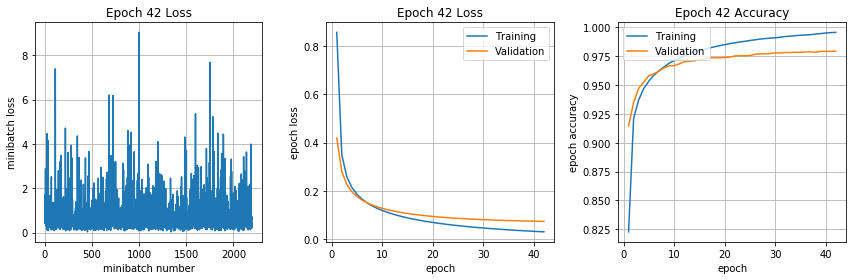

Iteration 92400: with minibatch training loss = 0.0184 and accuracy of 1
Iteration 92500: with minibatch training loss = 0.0404 and accuracy of 1
Iteration 92600: with minibatch training loss = 0.0213 and accuracy of 1
Iteration 92700: with minibatch training loss = 0.0227 and accuracy of 1
Iteration 92800: with minibatch training loss = 0.0091 and accuracy of 1
Iteration 92900: with minibatch training loss = 0.00852 and accuracy of 1
Iteration 93000: with minibatch training loss = 0.00761 and accuracy of 1
Iteration 93100: with minibatch training loss = 0.0101 and accuracy of 1
Iteration 93200: with minibatch training loss = 0.0126 and accuracy of 1
Iteration 93300: with minibatch training loss = 0.0435 and accuracy of 1
Iteration 93400: with minibatch training loss = 0.00313 and accuracy of 1
Iteration 93500: with minibatch training loss = 0.041 and accuracy of 1
Iteration 93600: with minibatch training loss = 0.0715 and accuracy of 0.96
Iteration 93700: with minibatch training loss 

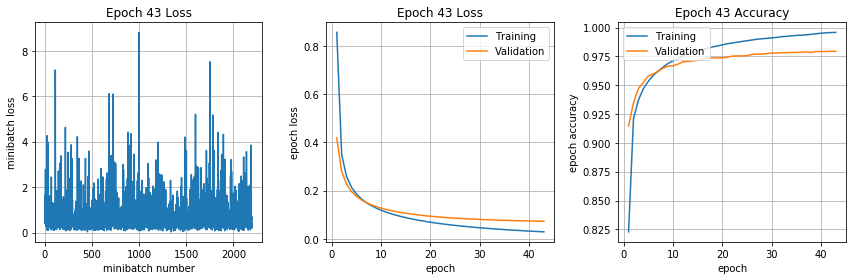

Iteration 94600: with minibatch training loss = 0.019 and accuracy of 1
Iteration 94700: with minibatch training loss = 0.0401 and accuracy of 1
Iteration 94800: with minibatch training loss = 0.0216 and accuracy of 1
Iteration 94900: with minibatch training loss = 0.022 and accuracy of 1
Iteration 95000: with minibatch training loss = 0.00898 and accuracy of 1
Iteration 95100: with minibatch training loss = 0.00839 and accuracy of 1
Iteration 95200: with minibatch training loss = 0.00743 and accuracy of 1
Iteration 95300: with minibatch training loss = 0.00965 and accuracy of 1
Iteration 95400: with minibatch training loss = 0.0121 and accuracy of 1
Iteration 95500: with minibatch training loss = 0.042 and accuracy of 1
Iteration 95600: with minibatch training loss = 0.00303 and accuracy of 1
Iteration 95700: with minibatch training loss = 0.04 and accuracy of 1
Iteration 95800: with minibatch training loss = 0.0685 and accuracy of 0.96
Iteration 95900: with minibatch training loss = 

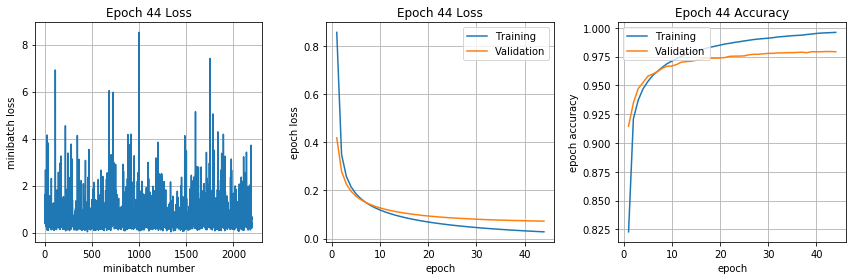

Iteration 96800: with minibatch training loss = 0.017 and accuracy of 1
Iteration 96900: with minibatch training loss = 0.0382 and accuracy of 1
Iteration 97000: with minibatch training loss = 0.0195 and accuracy of 1
Iteration 97100: with minibatch training loss = 0.0217 and accuracy of 1
Iteration 97200: with minibatch training loss = 0.00857 and accuracy of 1
Iteration 97300: with minibatch training loss = 0.00805 and accuracy of 1
Iteration 97400: with minibatch training loss = 0.00727 and accuracy of 1
Iteration 97500: with minibatch training loss = 0.00983 and accuracy of 1
Iteration 97600: with minibatch training loss = 0.0118 and accuracy of 1
Iteration 97700: with minibatch training loss = 0.0408 and accuracy of 1
Iteration 97800: with minibatch training loss = 0.00291 and accuracy of 1
Iteration 97900: with minibatch training loss = 0.0394 and accuracy of 1
Iteration 98000: with minibatch training loss = 0.0656 and accuracy of 1
Iteration 98100: with minibatch training loss =

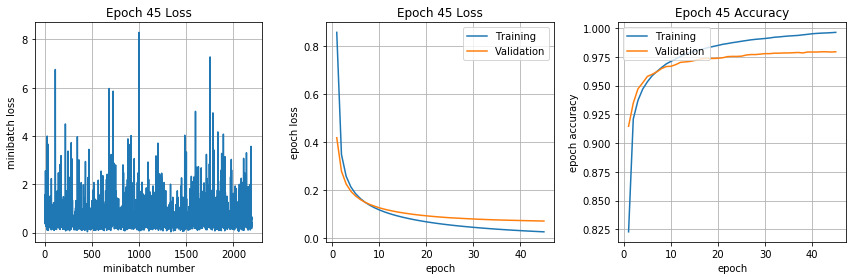

Iteration 99000: with minibatch training loss = 0.0168 and accuracy of 1
Iteration 99100: with minibatch training loss = 0.0382 and accuracy of 1
Iteration 99200: with minibatch training loss = 0.0192 and accuracy of 1
Iteration 99300: with minibatch training loss = 0.0214 and accuracy of 1
Iteration 99400: with minibatch training loss = 0.00838 and accuracy of 1
Iteration 99500: with minibatch training loss = 0.00787 and accuracy of 1
Iteration 99600: with minibatch training loss = 0.00709 and accuracy of 1
Iteration 99700: with minibatch training loss = 0.00958 and accuracy of 1
Iteration 99800: with minibatch training loss = 0.0116 and accuracy of 1
Iteration 99900: with minibatch training loss = 0.0395 and accuracy of 1
Iteration 100000: with minibatch training loss = 0.00278 and accuracy of 1
Iteration 100100: with minibatch training loss = 0.0384 and accuracy of 1
Iteration 100200: with minibatch training loss = 0.0631 and accuracy of 1
Iteration 100300: with minibatch training l

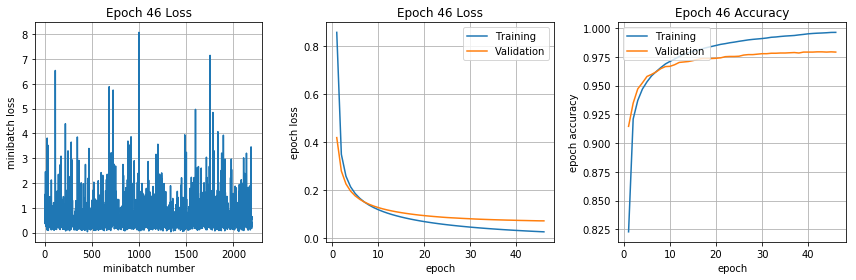

Iteration 101200: with minibatch training loss = 0.018 and accuracy of 1
Iteration 101300: with minibatch training loss = 0.0375 and accuracy of 1
Iteration 101400: with minibatch training loss = 0.0186 and accuracy of 1
Iteration 101500: with minibatch training loss = 0.0203 and accuracy of 1
Iteration 101600: with minibatch training loss = 0.00819 and accuracy of 1
Iteration 101700: with minibatch training loss = 0.00777 and accuracy of 1
Iteration 101800: with minibatch training loss = 0.00687 and accuracy of 1
Iteration 101900: with minibatch training loss = 0.00913 and accuracy of 1
Iteration 102000: with minibatch training loss = 0.0113 and accuracy of 1
Iteration 102100: with minibatch training loss = 0.0388 and accuracy of 1
Iteration 102200: with minibatch training loss = 0.0027 and accuracy of 1
Iteration 102300: with minibatch training loss = 0.0379 and accuracy of 1
Iteration 102400: with minibatch training loss = 0.0603 and accuracy of 1
Iteration 102500: with minibatch tr

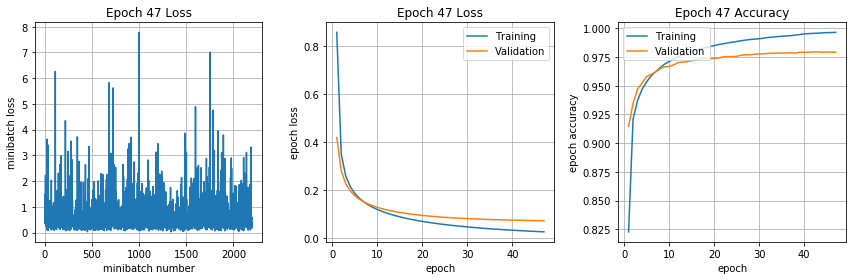

Iteration 103400: with minibatch training loss = 0.0159 and accuracy of 1
Iteration 103500: with minibatch training loss = 0.0364 and accuracy of 1
Iteration 103600: with minibatch training loss = 0.017 and accuracy of 1
Iteration 103700: with minibatch training loss = 0.0201 and accuracy of 1
Iteration 103800: with minibatch training loss = 0.00776 and accuracy of 1
Iteration 103900: with minibatch training loss = 0.00742 and accuracy of 1
Iteration 104000: with minibatch training loss = 0.0067 and accuracy of 1
Iteration 104100: with minibatch training loss = 0.00918 and accuracy of 1
Iteration 104200: with minibatch training loss = 0.011 and accuracy of 1
Iteration 104300: with minibatch training loss = 0.037 and accuracy of 1
Iteration 104400: with minibatch training loss = 0.00258 and accuracy of 1
Iteration 104500: with minibatch training loss = 0.0372 and accuracy of 1
Iteration 104600: with minibatch training loss = 0.0581 and accuracy of 1
Iteration 104700: with minibatch trai

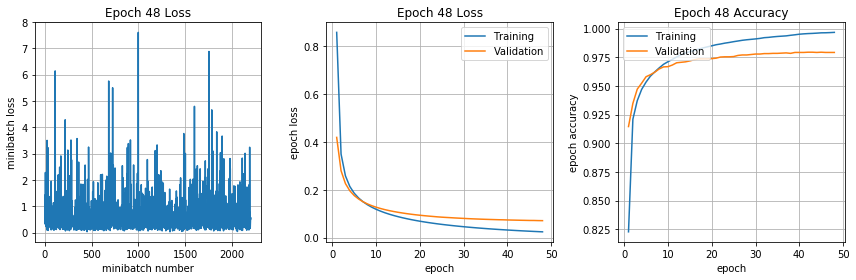

Iteration 105600: with minibatch training loss = 0.0153 and accuracy of 1
Iteration 105700: with minibatch training loss = 0.0355 and accuracy of 1
Iteration 105800: with minibatch training loss = 0.0164 and accuracy of 1
Iteration 105900: with minibatch training loss = 0.0197 and accuracy of 1
Iteration 106000: with minibatch training loss = 0.00758 and accuracy of 1
Iteration 106100: with minibatch training loss = 0.00724 and accuracy of 1
Iteration 106200: with minibatch training loss = 0.00643 and accuracy of 1
Iteration 106300: with minibatch training loss = 0.00838 and accuracy of 1
Iteration 106400: with minibatch training loss = 0.0108 and accuracy of 1
Iteration 106500: with minibatch training loss = 0.0364 and accuracy of 1
Iteration 106600: with minibatch training loss = 0.0025 and accuracy of 1
Iteration 106700: with minibatch training loss = 0.0364 and accuracy of 1
Iteration 106800: with minibatch training loss = 0.0558 and accuracy of 1
Iteration 106900: with minibatch t

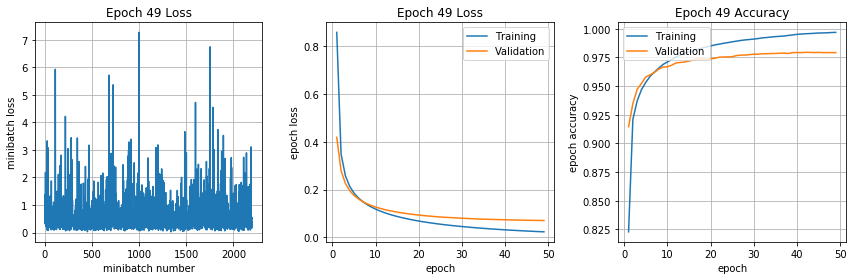

Iteration 107800: with minibatch training loss = 0.0148 and accuracy of 1
Iteration 107900: with minibatch training loss = 0.0346 and accuracy of 1
Iteration 108000: with minibatch training loss = 0.0157 and accuracy of 1
Iteration 108100: with minibatch training loss = 0.0192 and accuracy of 1
Iteration 108200: with minibatch training loss = 0.00734 and accuracy of 1
Iteration 108300: with minibatch training loss = 0.00702 and accuracy of 1
Iteration 108400: with minibatch training loss = 0.00633 and accuracy of 1
Iteration 108500: with minibatch training loss = 0.00851 and accuracy of 1
Iteration 108600: with minibatch training loss = 0.0103 and accuracy of 1
Iteration 108700: with minibatch training loss = 0.0347 and accuracy of 1
Iteration 108800: with minibatch training loss = 0.00239 and accuracy of 1
Iteration 108900: with minibatch training loss = 0.0358 and accuracy of 1
Iteration 109000: with minibatch training loss = 0.0538 and accuracy of 1
Iteration 109100: with minibatch 

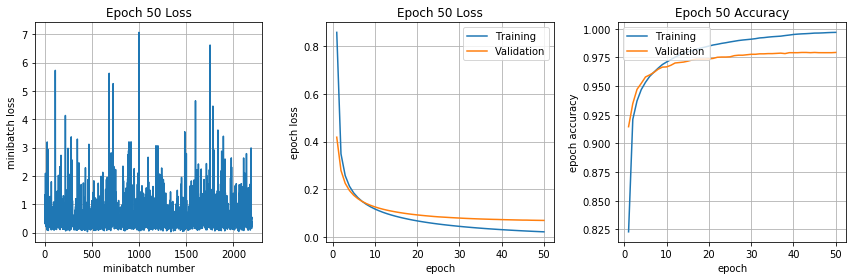

In [8]:
num_train = 1000
X_train_small= tf.to_float(X_train[:num_train], name='ToFloat')
y_train_small= tf.to_float(y_train[:num_train], name='ToFloat')

sess = tf.Session()

sess.run(tf.global_variables_initializer())
print('Training')


[loss,correct, loss_val,correct_val]=run_model(session=sess, predict=y_out, loss_val=mean_loss, Xd=X_train, yd=y_train,
              epochs=50, batch_size=25, print_every=100,
              training=train_step, plot_losses=True, X_val=X_val,y_val=y_val)